tl;dr : *Inférence du transfert des voix entre candidats.*

Afin d'analyser les résultats des élections, par exemple les dernières élections présidentielles de 2022 en France, et de mieux comprendre la dynamique des choix de vote entre les différents groupes de population, il peut être utile d'utiliser des outils d'apprentissage automatique pour inférer des données *a priori* cachées dans les données. En particulier, inspiré par cet [article du Monde](https://www.lemonde.fr/les-decodeurs/article/2022/05/04/election-presidentielle-2022-quels-reports-de-voix-entre-les-deux-tours_6124672_4355770.html), on peut se poser la question de savoir si on peut extraire depuis les données brutes des élections une estimation des report de voix entre les choix de vote au premier tour et ceux qui sont effectués au deuxième tour.

Pour cela nous allons utiliser les outils mathématiques de l'apprentissage automatique et en particulier l'utilisation des probabilités. Cette théorie va nous permettre d'exprimer le fait que les résultats telles qu'ils sont obtenus peuvent présenter une variabilité mais que celle-ci réelle résulte de préférence de chaque individu dans la population votante. En particulier, on peut considérer que chaque individu va avoir une préférence pour chacun des candidats au premier et second tour et que les votes effectués vont correspondre à la réalisation de ces préférences (en effet, on ne peut voter que pour un candidat par scrutin). 

Bien sûr on a accès ni au vote de chaque individu et encore moins à ses préférences. Mais comme mais comme chaque bureau de vote présente des variabilité liée au contexte local et qui fait que la population a une préférence pour certains choix plutôt que d'autres, on peut considérer chaque bureau de vote comme une population individuelle pour lequel nous allons essayer de prédire les résultats du vote au deuxième tour. Cette prediction, si elle est efficace, peut donner une idée du transfert de vote entre les deux tours qui a lieu en fonction des préférences des votes de chaque individu.

<!-- TEASER_END -->

Celà se modélise mathématiquement par un [processus de Bernoulli](https://fr.wikipedia.org/wiki/Processus_de_Bernoulli) relatif à ces préférences.

Grâce à l'ouverture des données (notamment pour la recherche), on peut obtenir librement les résultats des [premier](https://www.data.gouv.fr/fr/datasets/election-presidentielle-des-10-et-24-avril-2022-resultats-definitifs-du-1er-tour/) et [second](https://www.data.gouv.fr/fr/datasets/election-presidentielle-des-10-et-24-avril-2022-resultats-definitifs-du-2nd-tour/) tours. Il est intéressant de noter que ses résultats sont indiqués pour chacun des bureaux de vote. 

Pour cela nous allons faire deux hypothèses: 

Tout d'abord nous allons estimer que pour chaque individu, il existe une préférence pour les candidats du premier tour ainsi que pour les candidats du deuxieme tour. Si on note les différentes alternatives au premier tour comme $i \in \{ \text{'nul'}, \text{'abstention'}, \ldots, \text{'Macron'}, \text{'Poutou'} \}$ et au deuxième tour  $j \in \{ \text{'nul'}, \text{'abstention'}, \ldots, \text{'Macron'}, \text{'Le Pen'} \}$. Alors, on peut écrire pour chaque individu $k$ les probabilités de vote $p^k_i$ et $q^k_j$ (chacune de ces valeurs étant comprises entre $0$ et $1$ représentant un biais de probabilité pour chacune des alternatives). On pourra vérifier que $\forall k$ (pour tout individu),  $\sum_i p^k_i = 1$ et $\sum_j q^k_j = 1$.

Avec une telle modélisation on peut prévoir les résultats du vote car les préférences de chacun individu pour telle ou telle choix doit se révéler au niveau de la population totale suivant le théorème central limite qui indique que la moyenne observée tend vers ces probabilités avec une précision (inverse de la variance) qui augmente linéairement avec le nombre d'observations. En particulier les résultats des votes au premier et second tour seront donnés par respectivement $\frac 1 K \cdot \sum_k p^k_i$ et $\frac 1 K \cdot \sum_k q^k_j$ avec $K$ la taille de la population (nous vérifierons ce point plus bas).

Une deuxième hypothèse que nous allons faire et que si on considère la transition entre les préférences qui sont faites au premier tour et celles qui sont faites au second tour, les préférences évoluent avec chaque invidu mais la transition est homogène au sein de la population (par exemple "une personne qui choisit de s'abstenir s'abstiendra"). C'est certe une hypothèse grossière mais assez générale pour refléter les tendances au niveau de la population globale. Cette hypothèse est basée sur la modélisation de séquence d'événements aléatoires basé sur un [processus dit de Markov](https://fr.wikipedia.org/wiki/Cha%C3%AEne_de_Markov). En particulier nous allons formaliser cette hypothèse en faisant l'hypothèse de l'existence d'une matrice de transition $M$ qui permet de prédire la préférence $\hat{q}^k_j$ d'un individu au second tour à partir de ses préférences au premier tour. En particulier, cette hypothèse peut être formulée comme un simple produit matriciel :

$$
\hat{q}^k_j = \sum_i M_{i, j} \cdot p^k_i 
$$

En termes plus simples, cette formule exprime que la préférence d'un individu au second tour et le mélange de ses préférences individuelles au premier tour avec des poids indiquant les affinités entre les différentes alternatives aux deux tours. Il est important de noter qu'il existe une contrainte  pour chaque colonne de cette matrice de transition de sorte que la somme des différentes éléments sur les différentes lignes de la matrice pour chaque colonne est égal à $1$ : $\forall j$, $ \sum_i M_{i, j} = 1$. Cette propriété découle des contraintes de représentation des préférences au premier et au deuxième tour que nous avons évoquées plus haut ($\sum_i p^k_i = 1$ et $\sum_j q^k_j = 1$).

D'une cette certaine façon, cette matrice de transition décrit exactement les affinités de chacun des individus pour les différents choix de vote au niveau de la population globale. C'est donc un indicateur des report de vote qui vont être effectivement effectués entre les deux tours.

## Collecte des données

La première partie de ce travail consiste à collecter les données et elle est représenté d'une façon utile. On va utiliser les données disponibles sur https://www.data.gouv.fr en se concentrant sur les résultats définitifs par bureau de vote. 
Commençons notre procédure avec le traitement des données du premier tour. Une fois que nous aurons décortiqué cette méthode, nous passerons au deuxième tour.

### Données du premier tour

Pour cela nous allons utiliser deux premières librairie python : `numpy` pour le traitement de données numériques puis `pandas` pour la représentation deces données sous forme de tableau tableaux.

In [1]:
import numpy as np
import pandas as pd

On peut directement enregistrer à partir de l'adresse des données puis extraire ses données numériques depuis le tableau Excel grâce a la [fonction suivante](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html):

In [2]:
import os

In [3]:
fname = '/tmp/T1.xlsx'

if not os.path.isfile(fname):
    url = 'https://static.data.gouv.fr/resources/election-presidentielle-des-10-et-24-avril-2022-resultats-definitifs-du-1er-tour/20220414-152612/resultats-par-niveau-burvot-t1-france-entiere.xlsx' # XLSX
    import urllib.request
    urllib.request.urlretrieve(url, fname)


T1 = pd.read_excel(fname)

On peut avoir une première idée de ces données et du nombre total de bureaux de vote :

In [3]:
T1.tail()

,Code du département,Libellé du département,Code de la circonscription,Libellé de la circonscription,Code de la commune,Libellé de la commune,Code du b.vote,Inscrits,Abstentions,% Abs/Ins,...,Unnamed: 95,Unnamed: 96,Unnamed: 97,Unnamed: 98,Unnamed: 99,Unnamed: 100,Unnamed: 101,Unnamed: 102,Unnamed: 103,Unnamed: 104
69677,ZZ,Français établis hors de France,6,6ème circonscription,229,Zurich,0001,24868,14101,56.70,...,47,0.19,0.44,12,M,DUPONT-AIGNAN,Nicolas,189,0.76,1.77
69678,ZZ,Français établis hors de France,11,11ème circonscription,231,Taipei,0001,1709,942,55.12,...,10,0.59,1.32,12,M,DUPONT-AIGNAN,Nicolas,10,0.59,1.32
69679,ZZ,Français établis hors de France,11,11ème circonscription,233,Nour-Soultan,0001,117,64,54.70,...,0,0.00,0.00,12,M,DUPONT-AIGNAN,Nicolas,1,0.85,1.96
69680,ZZ,Français établis hors de France,2,2ème circonscription,234,Monterrey,0001,713,553,77.56,...,1,0.14,0.63,12,M,DUPONT-AIGNAN,Nicolas,1,0.14,0.63
69681,ZZ,Français établis hors de France,2,2ème circonscription,235,Bahamas (Nassau),0001,136,78,57.35,...,0,0.00,0.00,12,M,DUPONT-AIGNAN,Nicolas,1,0.74,1.82


Les données sont organisées suivant des colonnes qui vont représenter les différents choix et aussi d'autres métadonnées. Il va falloir faire quelques hypothèses pour récupérer les données utiles…

In [5]:
T1.columns

Index(['Code du département', 'Libellé du département',
       'Code de la circonscription', 'Libellé de la circonscription',
       'Code de la commune', 'Libellé de la commune', 'Code du b.vote',
       'Inscrits', 'Abstentions', '% Abs/Ins',
       ...
       'Unnamed: 95', 'Unnamed: 96', 'Unnamed: 97', 'Unnamed: 98',
       'Unnamed: 99', 'Unnamed: 100', 'Unnamed: 101', 'Unnamed: 102',
       'Unnamed: 103', 'Unnamed: 104'],
      dtype='object', length=105)

Première colonne concerne les nuls, blancs et abstention, que l'on peut enregistrer dans un nouveau tableau :

In [8]:
df_1 = T1[['Nuls', 'Blancs', 'Abstentions']].copy()
df_1.head()

,Nuls,Blancs,Abstentions
0,1,16,108
1,1,3,38
2,5,18,266
3,6,15,265
4,8,10,246


In [9]:
df_1

,Nuls,Blancs,Abstentions
0,1,16,108
1,1,3,38
2,5,18,266
3,6,15,265
4,8,10,246
...,...,...,...
69677,31,40,14101
69678,2,8,942
69679,0,2,64
69680,2,0,553


### extraction des résultats de vote

Les 23 premières colonnes correspondent aux métadonnées :

In [6]:
T1.columns[:23]

Index(['Code du département', 'Libellé du département',
       'Code de la circonscription', 'Libellé de la circonscription',
       'Code de la commune', 'Libellé de la commune', 'Code du b.vote',
       'Inscrits', 'Abstentions', '% Abs/Ins', 'Votants', '% Vot/Ins',
       'Blancs', '% Blancs/Ins', '% Blancs/Vot', 'Nuls', '% Nuls/Ins',
       '% Nuls/Vot', 'Exprimés', '% Exp/Ins', '% Exp/Vot', 'N°Panneau',
       'Sexe'],
      dtype='object')

Les colonnes suivant la colonne numéro 23 vont concerner les résultats candidats par candidats :

In [14]:
col_start = 23
col_par_cdt = 7

On peut extraire les noms des candidats présents au premier tour :

In [132]:
candidats = T1.iloc[0][col_start::col_par_cdt]
candidats

Nom                   ARTHAUD
Unnamed: 30           ROUSSEL
Unnamed: 37            MACRON
Unnamed: 44          LASSALLE
Unnamed: 51            LE PEN
Unnamed: 58           ZEMMOUR
Unnamed: 65         MÉLENCHON
Unnamed: 72           HIDALGO
Unnamed: 79             JADOT
Unnamed: 86          PÉCRESSE
Unnamed: 93            POUTOU
Unnamed: 100    DUPONT-AIGNAN
Name: 0, dtype: object

On peut par exemple extraire les résultats pour le premier bureau de vote et donner le nombre de suffrages exprimés pour chaque candidat :

In [133]:
résultats = T1.iloc[0][(col_start+2)::col_par_cdt]
résultats

Voix              3
Unnamed: 32       6
Unnamed: 39     150
Unnamed: 46      18
Unnamed: 53     149
Unnamed: 60      43
Unnamed: 67      66
Unnamed: 74       5
Unnamed: 81      30
Unnamed: 88      26
Unnamed: 95       3
Unnamed: 102     21
Name: 0, dtype: object

Grâce à ces connaissances, nous allons pouvoir maintenant récolter les données pour chaque candidat et pour tous les bureaux de vote en utilisant la fonction suivante :

In [16]:
for i_candidat, candidat in enumerate(candidats):
    i_col = col_start + i_candidat*col_par_cdt + 2
    print('# colonne', i_col, ' résultats=', T1.iloc[:, i_col].values)
    df_1[candidat] = T1.iloc[:, i_col].values

25 [3 2 4 ... 0 0 0]
32 [ 6  7 30 ...  1  1  1]
39 [150  50 159 ...  25  96  25]
46 [18 10 24 ...  1  1  0]
53 [149  23 237 ...   3   4   3]
60 [43 14 69 ...  7 18 17]
67 [ 66  41 216 ...   9  19   2]
74 [ 5  3 15 ...  0  2  0]
81 [30 10 25 ...  4 10  0]
88 [26  8 40 ...  0  5  6]
95 [3 3 8 ... 0 1 0]
102 [21  0 13 ...  1  1  1]


Nous avons récolté les données utiles dans un nouveau tableau :

In [19]:
print(df_1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69682 entries, 0 to 69681
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Nuls           69682 non-null  int64
 1   Blancs         69682 non-null  int64
 2   Abstentions    69682 non-null  int64
 3   ARTHAUD        69682 non-null  int64
 4   ROUSSEL        69682 non-null  int64
 5   MACRON         69682 non-null  int64
 6   LASSALLE       69682 non-null  int64
 7   LE PEN         69682 non-null  int64
 8   ZEMMOUR        69682 non-null  int64
 9   MÉLENCHON      69682 non-null  int64
 10  HIDALGO        69682 non-null  int64
 11  JADOT          69682 non-null  int64
 12  PÉCRESSE       69682 non-null  int64
 13  POUTOU         69682 non-null  int64
 14  DUPONT-AIGNAN  69682 non-null  int64
dtypes: int64(15)
memory usage: 8.0 MB
None


Ceci nous permet par exemple d'extraire les résultats pour un candidat donné et pour tous les bureaux de vote :

In [20]:
df_1['POUTOU']

0         3
1         3
2         8
3         4
4         3
         ..
69677    47
69678    10
69679     0
69680     1
69681     0
Name: POUTOU, Length: 69682, dtype: int64

En particulier, on a le nombre suivant de bureaux de vote :

In [134]:
len(df_1)

69670

Et on peut calculer pour chaque alternative le nombre total de choix ainsi que le nombre total de choix dans les data:

In [21]:
df_1.sum(), df_1.sum().sum()

(69682,
 Nuls               247151
 Blancs             543609
 Abstentions      12824169
 ARTHAUD            197094
 ROUSSEL            802422
 MACRON            9783058
 LASSALLE          1101387
 LE PEN            8133828
 ZEMMOUR           2485226
 MÉLENCHON         7712520
 HIDALGO            616478
 JADOT             1627853
 PÉCRESSE          1679001
 POUTOU             268904
 DUPONT-AIGNAN      725176
 dtype: int64,
 48747876)

Sous un format graphique on peut représenter ainsi les résultats du vote au premier tour et pour cela nous allons utiliser la librairie `matplotlib`:

In [22]:
import matplotlib.pyplot as plt

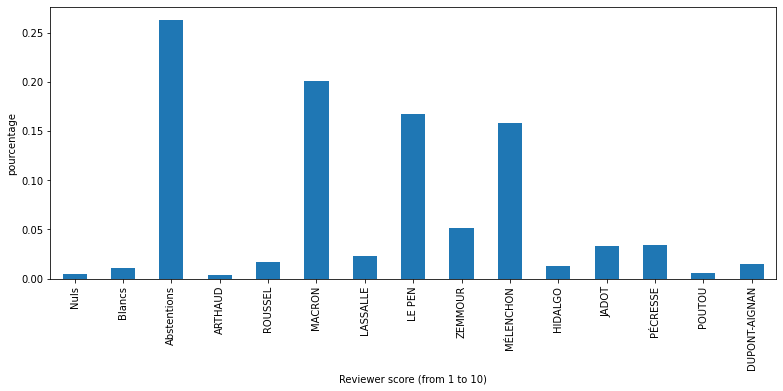

In [23]:
fig, ax = plt.subplots(figsize=(13, 5))
k = df_1.sum()/df_1.sum().sum()
ax = k.plot.bar(ax=ax)
ax.set_xlabel('Choix 1er tour')
ax.set_ylabel('Pourcentage');

On remarque le fort taux d'abstention qui a été observé au premier tour, ainsi que les deux candidats qui se distinguent par le plus grand nombre de voix et qui sont sélectionnés pour le second tour.

### données du 2ème tour

Nous allons maintenant répéter la même opération pour les données obtenues au deuxième tour :

In [24]:
fname = '/tmp/T2.xlsx'

if not os.path.isfile(fname):
    url = 'https://static.data.gouv.fr/resources/election-presidentielle-des-10-et-24-avril-2022-resultats-definitifs-du-2nd-tour/20220428-142301/resultats-par-niveau-burvot-t2-france-entiere.xlsx' # XLSX
    import urllib.request
    urllib.request.urlretrieve(url, fname)

T2 = pd.read_excel(fname)

T2.tail()

,Code du département,Libellé du département,Code de la circonscription,Libellé de la circonscription,Code de la commune,Libellé de la commune,Code du b.vote,Inscrits,Abstentions,% Abs/Ins,...,Voix,% Voix/Ins,% Voix/Exp,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34
69677,ZZ,Français établis hors de France,6,6ème circonscription,229,Zurich,0001,24867,13153,52.89,...,10166,40.88,88.88,2,F,LE PEN,Marine,1272,5.12,11.12
69678,ZZ,Français établis hors de France,11,11ème circonscription,231,Taipei,0001,1703,928,54.49,...,611,35.88,82.23,2,F,LE PEN,Marine,132,7.75,17.77
69679,ZZ,Français établis hors de France,11,11ème circonscription,233,Nour-Soultan,0001,117,64,54.70,...,39,33.33,78.00,2,F,LE PEN,Marine,11,9.40,22.00
69680,ZZ,Français établis hors de France,2,2ème circonscription,234,Monterrey,0001,715,510,71.33,...,181,25.31,89.60,2,F,LE PEN,Marine,21,2.94,10.40
69681,ZZ,Français établis hors de France,2,2ème circonscription,235,Bahamas (Nassau),0001,137,78,56.93,...,35,25.55,68.63,2,F,LE PEN,Marine,16,11.68,31.37


On vérifie que les données sont une nouvelle fois organisé suivant la même structure :

In [25]:
T2.columns

Index(['Code du département', 'Libellé du département',
       'Code de la circonscription', 'Libellé de la circonscription',
       'Code de la commune', 'Libellé de la commune', 'Code du b.vote',
       'Inscrits', 'Abstentions', '% Abs/Ins', 'Votants', '% Vot/Ins',
       'Blancs', '% Blancs/Ins', '% Blancs/Vot', 'Nuls', '% Nuls/Ins',
       '% Nuls/Vot', 'Exprimés', '% Exp/Ins', '% Exp/Vot', 'N°Panneau', 'Sexe',
       'Nom', 'Prénom', 'Voix', '% Voix/Ins', '% Voix/Exp', 'Unnamed: 28',
       'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32',
       'Unnamed: 33', 'Unnamed: 34'],
      dtype='object')

In [26]:
T2.columns[:23]

Index(['Code du département', 'Libellé du département',
       'Code de la circonscription', 'Libellé de la circonscription',
       'Code de la commune', 'Libellé de la commune', 'Code du b.vote',
       'Inscrits', 'Abstentions', '% Abs/Ins', 'Votants', '% Vot/Ins',
       'Blancs', '% Blancs/Ins', '% Blancs/Vot', 'Nuls', '% Nuls/Ins',
       '% Nuls/Vot', 'Exprimés', '% Exp/Ins', '% Exp/Vot', 'N°Panneau',
       'Sexe'],
      dtype='object')

In [27]:
T2.columns[23:]

Index(['Nom', 'Prénom', 'Voix', '% Voix/Ins', '% Voix/Exp', 'Unnamed: 28',
       'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32',
       'Unnamed: 33', 'Unnamed: 34'],
      dtype='object')

In [28]:
T2.iloc[0, 23:]

Nom              MACRON
Prénom         Emmanuel
Voix                237
% Voix/Ins        36.86
% Voix/Exp        52.67
Unnamed: 28           2
Unnamed: 29           F
Unnamed: 30      LE PEN
Unnamed: 31      Marine
Unnamed: 32         213
Unnamed: 33       33.13
Unnamed: 34       47.33
Name: 0, dtype: object

In [29]:
col_start = 23
col_par_cdt = 7
candidats = T2.iloc[0][col_start::col_par_cdt]
candidats

Nom            MACRON
Unnamed: 30    LE PEN
Name: 0, dtype: object

Une fois cette vérification faite nous pouvons extraire les données dans un nouveau tableau :

In [30]:
df_2 = T2[['Nuls', 'Blancs', 'Abstentions']].copy()
#df_1 = df_1.rename(columns={"Nuls": "1_Nuls", "Abstentions": "1_Abstentions"})
df_2.head()

,Nuls,Blancs,Abstentions
0,5,42,146
1,3,23,45
2,22,71,322
3,18,45,313
4,21,87,303


Nous vérifions aussi que nous avons le même nombre de bureaux de vote :

In [31]:
len(df_2)

69682

In [32]:
for i_candidat, candidat in enumerate(candidats):
    i_col = col_start + i_candidat*col_par_cdt + 2
    print(i_col, T2.iloc[:, i_col].values)
    df_2[candidat] = T2.iloc[:, i_col].values

25 [237  94 360 ...  39 181  35]
32 [213  48 355 ...  11  21  16]


In [35]:
df_2

,Nuls,Blancs,Abstentions,MACRON,LE PEN
0,5,42,146,237,213
1,3,23,45,94,48
2,22,71,322,360,355
3,18,45,313,426,327
4,21,87,303,449,353
...,...,...,...,...,...
69677,49,227,13153,10166,1272
69678,6,26,928,611,132
69679,0,3,64,39,11
69680,1,2,510,181,21


De la même façon que pour le premier tour, nous pouvons représenter les résultats totaux obtenus au second tour de façon graphique :

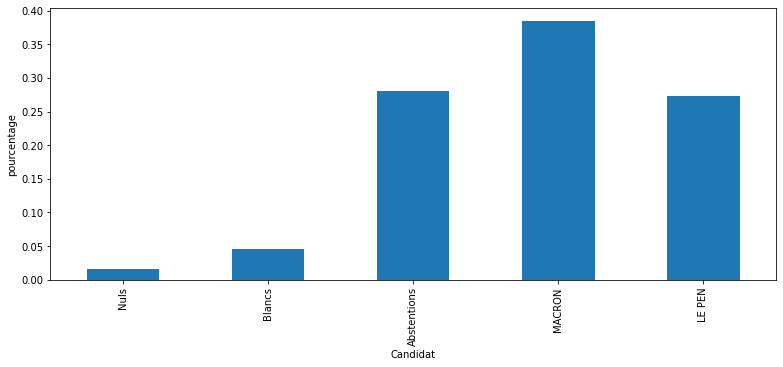

In [34]:
fig, ax = plt.subplots(figsize=(13, 5))
k = df_2.sum()/df_2.sum().sum()
ax = k.plot.bar(ax=ax)
ax.set_xlabel('Candidat')
#ax.set_xlim(1, 10)
#ax.set_xticks(np.arange(1, 10)+.5)
#ax.set_xticklabels(np.arange(1, 10)) , rotation=45
ax.set_ylabel('pourcentage');

### non aux nans

Certains bureaux de vote n'ont pas de votants au premier ou au deuxieme. Ceci peut engendrer des problèmes numériques en générant des divisions par zéro, des `Not a Number (NaN)` dans le jargon informatique. Comme ceux-ci représentent un nombre très faible d'électeurs nous allons les ignorer par rapport au reste de la population.

Nous pouvons d'abord compter le nombre de bureaux de vote qui n'ont aucun suffrage enregistré:

In [36]:
(df_1.sum(axis=1)==0).sum(), (df_2.sum(axis=1)==0).sum()

(10, 11)

Nous pouvons "effacer" ces bureaux du vote en commençant par filtrer ceux qui n'ont aucun suffrage enregistré au premier tour :

In [37]:
df_2.drop(df_2.loc[df_1.sum(axis=1)==0].index, inplace=True)
df_1.drop(df_1.loc[df_1.sum(axis=1)==0].index, inplace=True)

In [38]:
(df_1.sum(axis=1)==0).sum(), (df_2.sum(axis=1)==0).sum()

(0, 2)

Et maintenant répéter la même procédure sur les bureaux de vote qui n'ont aucun suffrage enregistré au second tour :

In [39]:
df_1.drop(df_1.loc[df_2.sum(axis=1)==0].index, inplace=True)
df_2.drop(df_2.loc[df_2.sum(axis=1)==0].index, inplace=True)

In [40]:
(df_1.sum(axis=1)==0).sum(), (df_2.sum(axis=1)==0).sum()

(0, 0)

### statistiques de second ordre

Comme cela est montré dans l'[article du Monde](https://www.lemonde.fr/les-decodeurs/article/2022/05/04/election-presidentielle-2022-quels-reports-de-voix-entre-les-deux-tours_6124672_4355770.html) on peut montrer la dépendance entre les choix qui sont effectués au premier tour et ceux qui sont effectués au deuxième tour. On va utiliser des représentations graphiques similaires à ceux de l'article pour d'une première part les répliquer et vérifier que la méthode est correct et d'un autre côté pour mieux comprendre comment nous pouvons tirer dans ses enseignements depuis ces observations.

In [41]:
df_12 = pd.DataFrame()

In [42]:
df_12['1_MÉLENCHON'] = df_1['MÉLENCHON'].copy()
df_12['MACRON'] = df_2['MACRON'].copy()

In [43]:
df_12.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69670 entries, 0 to 69681
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   1_MÉLENCHON  69670 non-null  int64
 1   MACRON       69670 non-null  int64
dtypes: int64(2)
memory usage: 1.6 MB


In [44]:
df_12['1_MÉLENCHON'] = df_12['1_MÉLENCHON']/df_1.sum(axis=1)
df_12['MACRON'] = df_12['MACRON']/df_2.sum(axis=1)

In [ ]:
sns.jointplot?

In [ ]:
sns.jointplot(x=df_12['1_MÉLENCHON'], y=df_12['MACRON'], kind='hist', height=13)

On remarque effectivement une dépendance entre le choix. Un premier candidat effectué au premier tour et celui qui est effectué au second tour. Nous allons essayer d'inférer de façon plus précise cette dépendance grâce au modèle de transition que nous avons exposer au début de cet article.

## fit model de transfert des voix

Tenant que nous avons récolté toutes les données pour les deux tours, et que nous avons une idée qu'il existe une dépendance entre les choix qui sont faits entre un tour et le suivant, nous allons pouvoir utiliser des librairies de tes apprentissage automatique machine Learning en anglais pour pouvoir insérer le report de voix entre les deux tours :. Pour cela nous allons utiliser un travail précédemment effectué appliquer à l'[exploration du comportement humain](https://laurentperrinet.github.io/sciblog/posts/2020-04-08-fitting-a-psychometric-curve-using-pytorch.html) ou alors pour [l'épidémiologie du Covid](https://laurentperrinet.github.io/sciblog/posts/2020-10-10-fitting-covid-data.html).

### Formatage des données au format de la librairie `torch`

Pendant un aperçu des résultats au premier tour :

In [51]:
df_1.head()

,Nuls,Blancs,Abstentions,ARTHAUD,ROUSSEL,MACRON,LASSALLE,LE PEN,ZEMMOUR,MÉLENCHON,HIDALGO,JADOT,PÉCRESSE,POUTOU,DUPONT-AIGNAN
0,1,16,108,3,6,150,18,149,43,66,5,30,26,3,21
1,1,3,38,2,7,50,10,23,14,41,3,10,8,3,0
2,5,18,266,4,30,159,24,237,69,216,15,25,40,8,13
3,6,15,265,6,13,201,19,210,68,194,19,46,42,4,20
4,8,10,246,8,18,229,28,227,74,227,16,65,35,3,19


Nous avons donc comptabilisé ces différentes alternatives au premier tour :

In [52]:
len(df_1.columns)

15

De sorte que sur les bureaux de vote que nous avons validé nous avons les deux tableaux suivants :

In [53]:
df_1.values.shape, df_2.values.shape

((69670, 15), (69670, 5))

Nous allons maintenant utiliser la librairie `torch` pour enregistrer ses données sous la forme d'une matrice (ou tenseur dans le jargon de cette librairie) :

In [ ]:
import torch

X_1, X_2 = df_1.values, df_2.values
x_1, x_2 = torch.Tensor(X_1), torch.Tensor(X_2)


In [56]:
x_1.shape

torch.Size([69670, 15])

Ainsi nous allons très facilement pouvoir représenter les données pour pouvoir les apprendre. Une pratique extrêmement importante dans l'apprentissage automatique et de séparer les données qui sont utilisés pour apprendre le modèle, avec celles qui sont utilisés pour tester ce modèle :

In [57]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(x_1, x_2)

# Random split
train_set_size = int(len(dataset) * 0.8)
test_set_size = len(dataset) - train_set_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_set_size, test_set_size])


Ainsi nous pourrons utiliser l'ensemble d'apprentissage au cours des différentes époques d'apprentissage utilisé plus bas :

In [59]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

In [60]:
for n_1, n_2 in train_loader:
    break

En particulier nous allons couper les données de façon aléatoire puis il est représenté sous la forme de différents « paquet » dont la taille est fixé ici à 32, et nous verrons plus tard que si cette procédure permet d'accélérer l'apprentissage la taille du paquet n'a plus d'influence sur le résultat final.

In [61]:
n_1.shape, n_2.shape

(torch.Size([32, 15]), torch.Size([32, 5]))

Dans chaque paquet nous pouvons compter le nombre de votes pour les différentes alternatives :

In [62]:
sum_1, sum_2 = n_1.sum(axis=1), n_2.sum(axis=1)
sum_1, sum_2

(tensor([ 318.,  299.,  147.,  865.,  396.,  132., 1018.,  788.,   85.,  866.,
          115., 1429.,  827.,  135.,  907., 1336., 1396., 1855., 1416.,  814.,
          569.,  366.,  891.,  430., 1105., 1314.,  103.,  825.,  681.,  679.,
          889.,  109.]),
 tensor([ 318.,  299.,  147.,  865.,  396.,  130., 1018.,  788.,   84.,  865.,
          115., 1429.,  828.,  135.,  907., 1337., 1396., 1855., 1417.,  814.,
          569.,  365.,  892.,  430., 1106., 1315.,  103.,  825.,  681.,  679.,
          889.,  109.]))

Nous pouvons aussi vérifier que parmi toutes les et les alternatives on peut calculer des fréquences d'occurrence, et que comme chaque individu peut faire un seul un choix est un seul, la somme de ses fréquences d'occurrence pour chacun des paquets est égal à $1$.

In [63]:
(n_1/sum_1[:, None]).sum(axis=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

Nous pourrons aussi aisément utiliser les données qui sont représentés dans l'ensemble de test :

In [64]:
n_1, n_2 = dataset[test_set.indices]
n_1.shape, n_2.shape

(torch.Size([13934, 15]), torch.Size([13934, 5]))

### Modèle `torch` de transition de probabilités


Maintenant que nous avons correctement formater les données, nous allons exprimer dans le langage de la librairie torche le modèle qui nous permet d'exprimer la transition entre les préférences au premier tour et les préférences au premier second tour. En particulier la matrice de transition sera définie par une matric `self.M` de telle sorte que quand on l'utilise, la contrainte qui fait que la somme des éléments colonne par colonne est bien égal à $1$ (utilisation de `torch.softmax(self.M, axis=0)`):

In [69]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

#torch.set_default_tensor_type("torch.DoubleTensor")
torch.set_default_tensor_type("torch.FloatTensor")

class TransfertVoix(torch.nn.Module):
    def __init__(self, N_1er, N_2eme):
        super(TransfertVoix, self).__init__()
        M = torch.randn((N_1er, N_2eme))
        self.M = torch.nn.Parameter(M, requires_grad=True)

    def forward(self, p_1):
        p_2_pred = torch.matmul(p_1, torch.softmax(self.M, axis=0))
        return p_2_pred

Ce modèle va utiliser comme dimension le nombre de différentes alternatives au premier et deuxième tour :

In [70]:
N_1er, N_2eme = len(df_1.columns), len(df_2.columns)
N_1er, N_2eme

(15, 5)

De telle sorte que nous allons pouvoir instancier un tel modèle, sachant que la matrice de transition sera choisi de façon totalement aléatoire et donc déconnecté des données à l'initialisation de cet apprentissage :

In [71]:
trans = TransfertVoix(N_1er, N_2eme)

In [72]:
for p in trans.parameters():print(p)

Parameter containing:
tensor([[-1.1503, -1.7576,  0.8764,  1.8400, -1.0808],
        [-1.4012,  0.1860, -0.5656,  0.5708,  0.3610],
        [-2.3048,  0.5064,  0.0408,  0.8580, -0.1220],
        [-0.3047, -0.4757,  0.9970,  1.1463, -0.0977],
        [-0.0670,  0.1642,  1.4305,  0.0879,  1.7368],
        [-0.7136, -0.6464, -1.7453, -0.5110, -0.4049],
        [ 0.8252, -0.2320,  1.4698, -0.5264, -0.0261],
        [-1.2302, -0.2282, -0.2555,  1.4513, -0.5961],
        [ 0.1125,  1.2150, -0.3149, -0.6257, -0.2353],
        [ 0.3697, -0.5496, -0.3497,  1.4393, -0.6891],
        [-2.8792, -2.0645, -1.1119, -0.2781,  1.5665],
        [-0.0145,  0.1981,  2.5291,  0.4745,  0.2777],
        [ 0.2312, -0.0596,  0.6422, -2.2059,  0.6454],
        [ 1.0139,  0.3615,  1.0312,  2.5526, -0.0058],
        [-3.0265, -0.2837, -0.0613, -0.0294,  1.2921]], requires_grad=True)


In [73]:
torch.softmax(trans.M, axis=0)

tensor([[0.0242, 0.0112, 0.0664, 0.1530, 0.0134],
        [0.0188, 0.0783, 0.0157, 0.0430, 0.0565],
        [0.0076, 0.1079, 0.0288, 0.0573, 0.0349],
        [0.0564, 0.0404, 0.0750, 0.0764, 0.0357],
        [0.0715, 0.0767, 0.1156, 0.0265, 0.2238],
        [0.0375, 0.0341, 0.0048, 0.0146, 0.0263],
        [0.1746, 0.0516, 0.1203, 0.0144, 0.0384],
        [0.0224, 0.0518, 0.0214, 0.1037, 0.0217],
        [0.0856, 0.2192, 0.0202, 0.0130, 0.0311],
        [0.1107, 0.0375, 0.0195, 0.1025, 0.0198],
        [0.0043, 0.0083, 0.0091, 0.0184, 0.1887],
        [0.0754, 0.0793, 0.3469, 0.0390, 0.0520],
        [0.0964, 0.0613, 0.0526, 0.0027, 0.0751],
        [0.2109, 0.0934, 0.0776, 0.3120, 0.0392],
        [0.0037, 0.0490, 0.0260, 0.0236, 0.1434]], grad_fn=<SoftmaxBackward0>)

Nous vérifions que la contrainte sur chaque colonne de la matrice de transition et bien vérifiée :

In [74]:
torch.softmax(trans.M, axis=0).sum(axis=0)

(tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>),
 tensor([0.2682, 0.2124, 0.2365, 0.2840, 0.5141, 0.1172, 0.3992, 0.2210, 0.3692,
         0.2900, 0.2288, 0.5927, 0.2881, 0.7329, 0.2457],
        grad_fn=<SumBackward1>))

Exprimons maintenant pour chacun des bureaux de vote les probabilités de préférence qui sont exprimées localement :

In [76]:
sum_1, sum_2 = n_1.sum(axis=1), n_2.sum(axis=1)
p_1 = n_1/sum_1[:, None]

Cette probabilité va pouvoir être multiplié par la matrice de transition de probabilité et nous vérifions dans les lignes suivantes la compatibilité entre les différentes dimensions des données représentées :

In [77]:
p_1.shape, p_1.sum(axis=1)

(torch.Size([13934, 15]),
 tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]))

In [78]:
p_1.shape, trans.M.shape

(torch.Size([13934, 15]), torch.Size([15, 5]))

In [79]:
torch.matmul(p_1, torch.softmax(trans.M, axis=0)).shape

torch.Size([13934, 5])

In [80]:
torch.tensordot(p_1, torch.softmax(trans.M, axis=0), dims=1)

tensor([[0.0419, 0.0676, 0.0313, 0.0610, 0.0384],
        [0.0562, 0.0666, 0.0258, 0.0646, 0.0296],
        [0.0504, 0.0675, 0.0333, 0.0616, 0.0363],
        ...,
        [0.0469, 0.0734, 0.0393, 0.0630, 0.0372],
        [0.0419, 0.0666, 0.0246, 0.0541, 0.0352],
        [0.0413, 0.0720, 0.0281, 0.0663, 0.0328]],
       grad_fn=<ReshapeAliasBackward0>)

Ces différentes vérifications nous permettent de valider l'utilisation directe du modèle pour prédire la probabilité de préférence dans ce bureau de vote au second tour à partir de celle observée au premier tour :

In [82]:
p_2_pred = trans(n_1/sum_1[:, None])
p_2_pred.mean(axis=0), p_2_pred.mean(axis=0).sum()

(tensor([0.0487, 0.0698, 0.0361, 0.0587, 0.0376], grad_fn=<MeanBackward1>),
 tensor(0.2508, grad_fn=<SumBackward0>))

Au cours de l'apprentissage, nous allons pouvoir comparer cette probabilité prédit avec celle qui a été effectivement observée :

In [83]:
p_2 = n_2/sum_2[:, None]
p_2.mean(axis=0), p_2.mean(axis=0).sum()

(tensor([0.0187, 0.0499, 0.2563, 0.3691, 0.3060]), tensor(1.))

Nous allons aussi vérifier graphiquement que les résultats moyen des votes au second tour peuvent être inférer à partir des données de probabilité multiplié par la taille de chacun des bureaux de vote :

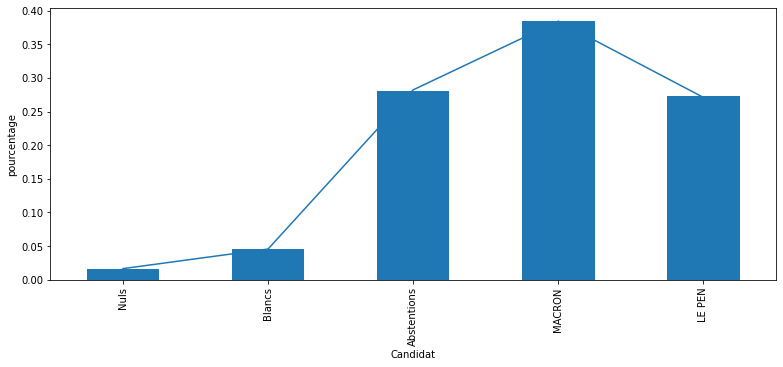

In [84]:
fig, ax = plt.subplots(figsize=(13, 5))
k = df_2.sum()/df_2.sum().sum()
ax = k.plot.bar(ax=ax)
p_2_average = (p_2*sum_2[:, None]).sum(axis=0)/sum_2.sum()
ax.plot(p_2_average)
ax.set_xlabel('Candidat')
ax.set_ylabel('pourcentage');

Ainsi que la concordance entre les résultats finaux obtenu est ce que nous représentons dans notre modèle :

In [102]:
k*100, p_2_average*100

(Nuls            1.651714
 Blancs          4.582147
 Abstentions    28.010677
 MACRON         38.497926
 LE PEN         27.257536
 dtype: float64,
 tensor([ 1.8803,  4.9658, 25.4675, 36.9061, 30.7802]))

### Modèle `torch` d'apprentissage:

Maintenant que nous avons défini le modèle de transition des probabilités entre les préférences au premier tour et au second tour, nous pouvons maintenant écrire un algorithme d'apprentissage qui permet d'optimiser la concordance entre la prédiction et les observations. 

Nous allons utiliser les distributions observées $q$ et prédites $\hat{q}$ (celle-ci dépendant de $M$) pour calculer un coût à minimiser
$$
\mathcal{L} =  KL(q, \hat{q})
$$

où la [divergence de Kullback-Leibler](https://fr.wikipedia.org/wiki/Divergence_de_Kullback-Leibler) est calculée comme

$$
KL(P, Q) = \sum_j P_j \cdot \log \frac {P_j}{Q_j}
$$


Cette divergence est l'équivalent d'une distance dans les espaces de probabilité. Mathémamatiquement, c'est une semi-normes car elle obéit à deux propriétés fondamentales: elle est toujours positive et est égale à zéro quand elle est appliquée à distributions identiques.

In [105]:
F.kl_div?

Signature:
F.kl_div(
    input: torch.Tensor,
    target: torch.Tensor,
    size_average: Optional[bool] = None,
    reduce: Optional[bool] = None,
    reduction: str = 'mean',
    log_target: bool = False,
) -> torch.Tensor
Docstring:
The `Kullback-Leibler divergence Loss
<https://en.wikipedia.org/wiki/Kullback-Leibler_divergence>`__

See :class:`~torch.nn.KLDivLoss` for details.

Args:
    input: Tensor of arbitrary shape in log-probabilities.
    target: Tensor of the same shape as input. See :attr:`log_target` for
        the target's interpretation.
    size_average (bool, optional): Deprecated (see :attr:`reduction`). By default,
        the losses are averaged over each loss element in the batch. Note that for
        some losses, there multiple elements per sample. If the field :attr:`size_average`
        is set to ``False``, the losses are instead summed for each minibatch. Ignored
        when reduce is ``False``. Default: ``True``
    reduce (bool, optional): Deprecated (se

In [106]:
    F.kl_div(p_2_average.log(), p_2_average.log(), reduction='none')

tensor([0., 0., 0., 0., 0.])

In [110]:
F.kl_div(p_2_average, p_2_average, reduction='none', log_target=False)

tensor([-0.0751, -0.1515, -0.4086, -0.4455, -0.4252])

In [ ]:
p_2_pred.mean(axis=0), p_2_average

In [ ]:
p_2_pred.mean(axis=0).sum(axis=1), p_2_average.sum(axis=1)

In [147]:
F.kl_div(p_2_pred.mean(axis=0), p_2_average, reduction='none', log_target=False)

tensor([-0.0792, -0.1611, -0.4096, -0.4567, -0.4367])

In [228]:
import torch.nn.functional as F

# https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html
criterion = torch.nn.CrossEntropyLoss(reduction="mean")
# https://pytorch.org/docs/master/generated/torch.nn.BCELoss.html
criterion = torch.nn.BCELoss(reduction="mean")
# https://pytorch.org/docs/master/generated/torch.nn.KLDivLoss.html
criterion = torch.nn.KLDivLoss(reduction="mean") # attention - prend des log probas en entrée!

learning_rate = 0.01
beta1, beta2 = 0.9, 0.999
num_epochs = 2 ** 12 + 1
batch_size = 1024
amsgrad = True  # gives similar results
amsgrad = False # gives similar results

def fit_data(
    df_1,
    df_2,
    learning_rate=learning_rate,
    batch_size=batch_size,  # gamma=gamma,
    num_epochs=num_epochs,
    beta1=beta1,
    beta2=beta2,
    split_ratio=.8, seed=42,
    verbose=False, **kwargs
):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    N_1er, N_2eme = len(df_1.columns), len(df_2.columns)
    trans = TransfertVoix(N_1er, N_2eme)
    # print(trans.M)
    trans = trans.to(device)

    X_1, X_2 = df_1.values, df_2.values
    x_1, x_2 = torch.Tensor(X_1), torch.Tensor(X_2)

    # split train and test
    from torch.utils.data import TensorDataset, DataLoader
    dataset = TensorDataset(x_1, x_2)
    # Random split
    train_set_size = int(len(dataset) * split_ratio)
    test_set_size = len(dataset) - train_set_size
    train_set, test_set = random_split(dataset, [train_set_size, test_set_size], generator=torch.Generator().manual_seed(seed))
    train_loader = DataLoader(train_set, batch_size=int(batch_size), shuffle=True)

    # apprentissage
    trans.train()
    optimizer = torch.optim.Adam(trans.parameters(), lr=learning_rate, betas=(beta1, beta2), amsgrad=amsgrad)
    for epoch in range(int(num_epochs)):
        losses = []
        for n_1, n_2 in train_loader:
            n_1, n_2 = n_1.to(device), n_2.to(device)

            sum_1, sum_2 = n_1.sum(axis=1), n_2.sum(axis=1)
            p_1 = n_1/sum_1[:, None]
            p_2 = n_2/sum_2[:, None]
            #p_2[p_2==0] = 1.

            p_2_pred = trans(p_1)
            #p_2_pred[p_2_pred==0] = 1.
            #print(p_2_pred.mean(axis=0))
            #print(p_2_pred.mean(axis=0).sum())
            ind_nonzero = (p_2==0) + (p_2_pred==0)
            p_2[ind_nonzero] = 1.
            p_2_pred[ind_nonzero] = 1.
            
            #print(p_2_pred.shape, p_2_pred.min(), p_2_pred.max())
            #loss = criterion(p_2_pred, p_2, weight=sum_1/sum_1.sum())
            weight = sum_2/sum_2.sum()
            #print(p_2_pred.shape, p_2.shape, weight.shape)
            #loss = F.binary_cross_entropy(p_2_pred, p_2, reduction="sum", weight=weight[:, None])
            
            kl_div = p_2 * (p_2.log() - p_2_pred.log())
            loss = (kl_div * weight[:, None]).sum() # donne un poids à chaque bureau de vote proposrtionnel à sa taille
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

            #with torch.no_grad():
            #    trans.M = torch.nn.Parameter(trans.M / trans.M.sum(axis=1, keepdim=True))


        if verbose: # and (epoch % (num_epochs // 1024) == 0):
            print(f"Iteration: {epoch} - Loss: {np.sum(losses):.5e}")

    # print(trans.M)

    #n_1, n_2
    # Test
    #trans.eval()
    with torch.no_grad():
        n_1, n_2 = dataset[test_set.indices]
        sum_1, sum_2 = n_1.sum(axis=1), n_2.sum(axis=1)
        p_2 = n_2/sum_2[:, None]
        p_1 = n_1/sum_1[:, None]
        p_2_pred = trans(p_1)
    
    return trans, np.sum(losses), p_1, p_2, p_2_pred

In [229]:
trans, losses, p_1, p_2, p_2_pred = fit_data(df_1, df_2, verbose=True)

Iteration: 0 - Loss: 2.14516e+02
Iteration: 1 - Loss: 9.11146e+01
Iteration: 2 - Loss: 8.43182e+01
Iteration: 3 - Loss: 8.27240e+01
Iteration: 4 - Loss: 8.20519e+01
Iteration: 5 - Loss: 8.17146e+01
Iteration: 6 - Loss: 8.15918e+01
Iteration: 7 - Loss: 8.16291e+01
Iteration: 8 - Loss: 8.13951e+01
Iteration: 9 - Loss: 8.12814e+01
Iteration: 10 - Loss: 8.11927e+01
Iteration: 11 - Loss: 8.13130e+01
Iteration: 12 - Loss: 8.12151e+01
Iteration: 13 - Loss: 8.12137e+01
Iteration: 14 - Loss: 8.12274e+01
Iteration: 15 - Loss: 8.13047e+01
Iteration: 16 - Loss: 8.12497e+01
Iteration: 17 - Loss: 8.13963e+01
Iteration: 18 - Loss: 8.11304e+01
Iteration: 19 - Loss: 8.12154e+01
Iteration: 20 - Loss: 8.12885e+01
Iteration: 21 - Loss: 8.12145e+01
Iteration: 22 - Loss: 8.13128e+01
Iteration: 23 - Loss: 8.10911e+01
Iteration: 24 - Loss: 8.12294e+01
Iteration: 25 - Loss: 8.11731e+01
Iteration: 26 - Loss: 8.13032e+01
Iteration: 27 - Loss: 8.12181e+01
Iteration: 28 - Loss: 8.10748e+01
Iteration: 29 - Loss: 8.

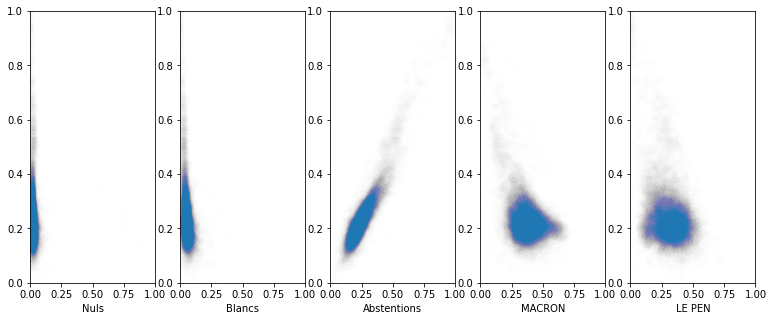

In [230]:
fig, axs = plt.subplots(1, N_2eme, figsize=(13, 5))
for i_col, candidat in enumerate(df_2.columns):
    #print(candidat)
    axs[i_col].scatter(p_2[:,i_col], p_2_pred[:,i_col], alpha=.005)
    axs[i_col].set_xlabel(candidat)
    axs[i_col].set_xlim(0, 1)
    axs[i_col].set_ylim(0, 1)

In [231]:
p_2.shape

torch.Size([13934, 5])

In [232]:
import torch.nn.functional as F

In [233]:
p_2_pred.mean(axis=0), p_2.mean(axis=0).sum()

(tensor([0.2406, 0.2406, 0.2406, 0.2351, 0.2406]), tensor(1.))

In [234]:
p_2_average = (p_2*sum_2[:, None]).sum(axis=0)/sum_2.sum()
p_2_average

tensor([0.0188, 0.0497, 0.2547, 0.3691, 0.3078])

In [235]:
p_2_pred_average = (p_2_pred*sum_2[:, None]).sum(axis=0)/sum_2.sum()
p_2_pred_average

tensor([0.2416, 0.2416, 0.2416, 0.2360, 0.2416])

In [236]:
M = torch.softmax(trans.M, axis=0).detach().numpy()
M

array([[0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [1. , 1. , 1. , 0.9, 1. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.1, 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ]], dtype=float32)

In [237]:
M.sum(axis=0), M.shape

(array([1., 1., 1., 1., 1.], dtype=float32), (15, 5))

https://matplotlib.org/stable/gallery/misc/table_demo.html#sphx-glr-gallery-misc-table-demo-py

In [238]:
df_1.columns, df_2.columns

(Index(['Nuls', 'Blancs', 'Abstentions', 'ARTHAUD', 'ROUSSEL', 'MACRON',
        'LASSALLE', 'LE PEN', 'ZEMMOUR', 'MÉLENCHON', 'HIDALGO', 'JADOT',
        'PÉCRESSE', 'POUTOU', 'DUPONT-AIGNAN'],
       dtype='object'),
 Index(['Nuls', 'Blancs', 'Abstentions', 'MACRON', 'LE PEN'], dtype='object'))

In [239]:

data = [[ 66386, 174296,  75131, 577908,  32015],
        [ 58230, 381139,  78045,  99308, 160454],
        [ 89135,  80552, 152558, 497981, 603535],
        [ 78415,  81858, 150656, 193263,  69638],
        [139361, 331509, 343164, 781380,  52269]]
data, len(data)

([[66386, 174296, 75131, 577908, 32015],
  [58230, 381139, 78045, 99308, 160454],
  [89135, 80552, 152558, 497981, 603535],
  [78415, 81858, 150656, 193263, 69638],
  [139361, 331509, 343164, 781380, 52269]],
 5)

Text(0.5, 1.0, 'Vote second tour')

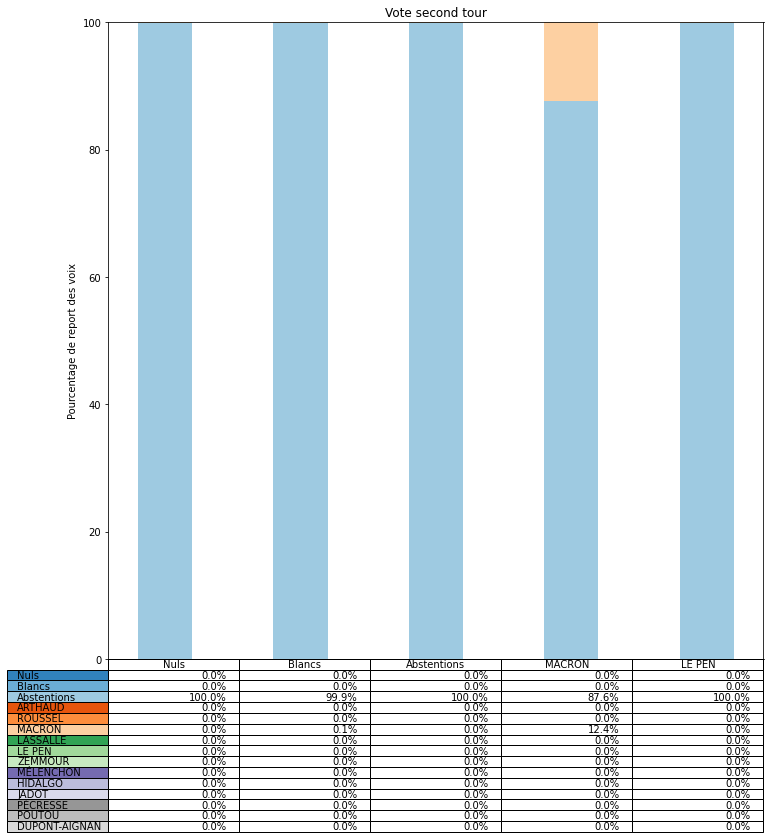

In [240]:
fig, ax = plt.subplots(figsize=(13, 13))

columns = df_2.columns
rows = df_1.columns

# Get some pastel shades for the colors
colors = plt.cm.tab20c(np.linspace(0, 1, len(rows)))
n_rows = len(rows)

index = np.arange(len(columns)) + 0.3
bar_width = 0.4

# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.zeros(len(columns))

# Plot bars and create text labels for the table
cell_text = []
for row in range(n_rows):
    ax.bar(index, M[row]*100, bar_width, bottom=y_offset, color=colors[row])
    y_offset = y_offset + M[row]*100
    cell_text.append([f'{x*100:1.1f}%' for x in M[row]])
# Reverse colors and text labels to display the last value at the top.
# colors = colors[::-1]
# cell_text.reverse()

# Add a table at the bottom of the axes
the_table = ax.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      colLabels=columns,
                      loc='bottom')

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=0.2)

plt.ylabel("Pourcentage de report des voix")
plt.yticks(np.linspace(0, 100, 6, endpoint=True))
plt.xticks([])
plt.title("Vote second tour")

In [241]:
np.set_printoptions(precision=1)
np.set_printoptions(suppress=True)
M*100

array([[  0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ],
       [100. ,  99.9, 100. ,  87.6, 100. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0.1,   0. ,  12.4,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ]], dtype=float32)

In [242]:
y_offset = np.zeros(len(columns))

# Plot bars and create text labels for the table
cell_text = []
for row in range(n_rows):
    y_offset = y_offset + M[row]
y_offset

array([1., 1., 1., 1., 1.])

### influence des parametres

In [243]:
N_scan = 7
results = []

learning_rates = learning_rate * np.logspace(-1, 1, 7, base=10)
for learning_rate_ in learning_rates:
    trans, loss, p_1, p_2, p_2_pred = fit_data(df_1, df_2, learning_rate=learning_rate_, verbose=False)
    results.append(loss)

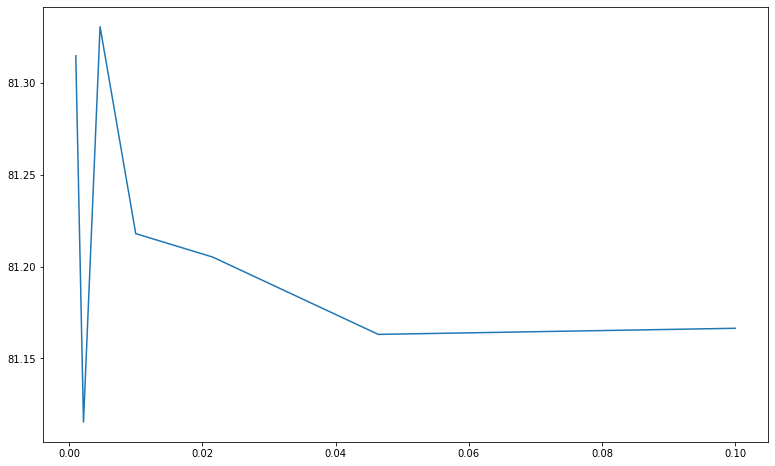

In [244]:
fig, ax = plt.subplots(figsize = (13, 8))
ax.plot(learning_rates, results)
ax.set_xlabel = 'learning rate'
ax.set_ylabel = 'Loss'

In [245]:
import time
results = []
batch_sizes = (batch_size * np.arange(1, N_scan) ** 2) // 8
print(batch_sizes)
for batch_size_ in batch_sizes:
    tic = time.time()
    trans, loss, p_1, p_2, p_2_pred = fit_data(df_1, df_2, batch_size=batch_size_, verbose=False)
    print(f'Pour batch_size= {batch_size_}, le temps de calcul est {time.time()-tic:.3f} s')
    results.append(loss)

[ 16  64 144 256 400 576]
Pour batch_size= 16, le temps de calcul est 71.034 s
Pour batch_size= 64, le temps de calcul est 25.444 s
Pour batch_size= 144, le temps de calcul est 19.529 s
Pour batch_size= 256, le temps de calcul est 18.655 s
Pour batch_size= 400, le temps de calcul est 16.574 s
Pour batch_size= 576, le temps de calcul est 16.583 s


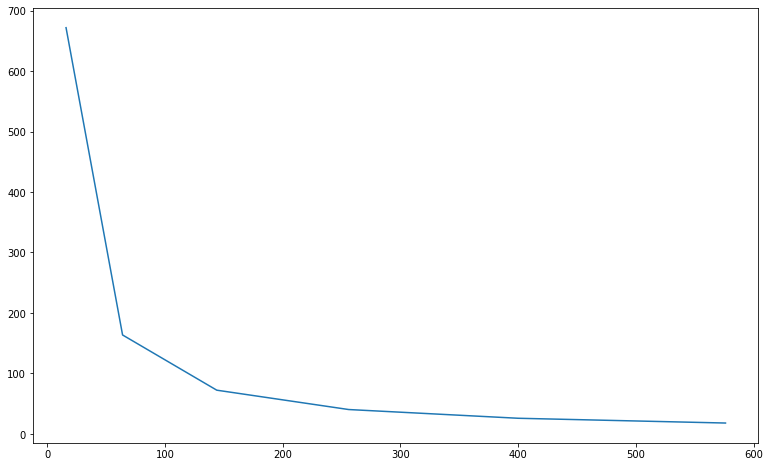

In [246]:
fig, ax = plt.subplots(figsize = (13, 8))
ax.plot(batch_sizes, results)
ax.set_xlabel = 'batch size'
ax.set_ylabel = 'Loss'

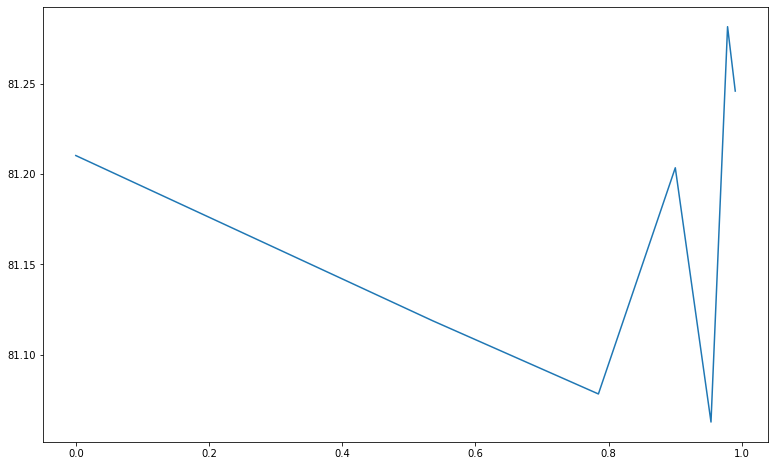

In [247]:
results = []
beta1s = 1 - (1 - beta1) * np.logspace(-1, 1, 7, base=10)
for beta1_ in beta1s:
    trans, loss, p_1, p_2, p_2_pred = fit_data(df_1, df_2, beta1=beta1_, verbose=False)
    results.append(loss)

fig, ax = plt.subplots(figsize = (13, 8))
ax.plot(beta1s, results)
ax.set_xlabel = 'beta1'
ax.set_ylabel = 'Loss'

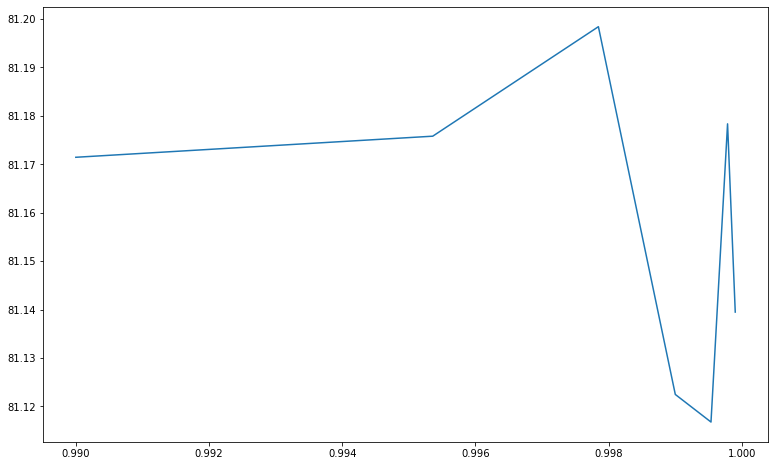

In [248]:
results = []
beta2s = 1 - (1 - beta2) * np.logspace(-1, 1, 7, base=10)
for beta2_ in beta2s:
    trans, loss, p_1, p_2, p_2_pred = fit_data(df_1, df_2, beta2=beta2_, verbose=False)
    results.append(loss)

fig, ax = plt.subplots(figsize = (13, 8))
ax.plot(beta2s, results)
ax.set_xlabel = 'beta2'
ax.set_ylabel = 'Loss'